In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

digit = datasets.load_digits()
print(digit.data,digit.target)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]] [0 1 2 ... 8 9 8]


In [2]:
digit.data.shape

(1797, 64)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digit.data, digit.target, test_size=0.3, random_state=42)

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
y_test_tensor.shape

torch.Size([540])

In [6]:
import torch.optim as optim
class diabetesDense(nn.Module):
    def __init__(self):
        super(diabetesDense, self).__init__()
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = diabetesDense().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses = []
test_accuracies = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        # 입력 데이터 shape 변환: (batch, 64) -> (batch, 1, 8, 8)
        batch_x = batch_x.float()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    # 테스트 정확도 계산
    model.eval()
    with torch.no_grad():
        test_x = X_test_tensor.float()
        test_outputs = model(test_x)
        _, predicted = torch.max(test_outputs.data, 1)
        correct = (predicted == y_test).sum().item()
        accuracy = correct / len(y_test)
        test_accuracies.append(accuracy)
        print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")



Test Accuracy: 0.6852
Epoch 1/50, Loss: 2.0280, Accuracy: 0.69%
Test Accuracy: 0.7481
Epoch 2/50, Loss: 1.8292, Accuracy: 0.75%
Test Accuracy: 0.8389
Epoch 3/50, Loss: 1.7253, Accuracy: 0.84%
Test Accuracy: 0.8685
Epoch 4/50, Loss: 1.6578, Accuracy: 0.87%
Test Accuracy: 0.8926
Epoch 5/50, Loss: 1.6150, Accuracy: 0.89%
Test Accuracy: 0.9074
Epoch 6/50, Loss: 1.5895, Accuracy: 0.91%
Test Accuracy: 0.9296
Epoch 7/50, Loss: 1.5673, Accuracy: 0.93%
Test Accuracy: 0.9426
Epoch 8/50, Loss: 1.5504, Accuracy: 0.94%
Test Accuracy: 0.9407
Epoch 9/50, Loss: 1.5440, Accuracy: 0.94%
Test Accuracy: 0.9389
Epoch 10/50, Loss: 1.5352, Accuracy: 0.94%
Test Accuracy: 0.9481
Epoch 11/50, Loss: 1.5256, Accuracy: 0.95%
Test Accuracy: 0.9481
Epoch 12/50, Loss: 1.5180, Accuracy: 0.95%
Test Accuracy: 0.9537
Epoch 13/50, Loss: 1.5173, Accuracy: 0.95%
Test Accuracy: 0.9519
Epoch 14/50, Loss: 1.5133, Accuracy: 0.95%
Test Accuracy: 0.9519
Epoch 15/50, Loss: 1.5075, Accuracy: 0.95%
Test Accuracy: 0.9481
Epoch 16/50,

In [11]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# 모델 평가 모드로 변경
model.eval()

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동

# 결과 저장
all_labels = []
all_predictions = []

# 평가 데이터 처리
with torch.no_grad():
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.float().to(device)  # GPU로 이동
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)  # 수정: torch.max의 반환값 언패킹
        
        all_labels.extend(batch_y.cpu().numpy())  # CPU로 이동 후 numpy로 변환
        all_predictions.extend(predicted.cpu().numpy())  # CPU로 이동 후 numpy로 변환

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[123   0   0   0   1   0   1   0   0   0]
 [  0 132   0   0   0   0   0   0   0   0]
 [  0   0 130   0   0   0   0   0   0   0]
 [  0   0   0 129   0   0   0   0   0   0]
 [  0   1   0   0 118   0   0   1   0   1]
 [  0   0   0   0   0 114   0   0   0   2]
 [  0   0   0   0   0   0 128   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0]
 [  0   4   0   0   0   0   0   0 127   0]
 [  0   0   0   1   0   1   0   0   0 119]]
F1 Score: 0.99
Precision: 0.99
Recall: 0.99
Specificity: 1.00


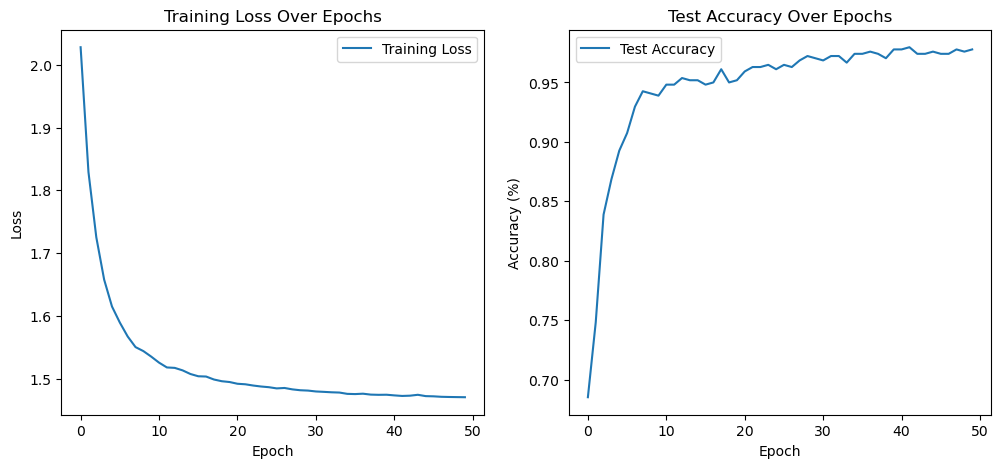

In [12]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()